# Step 0: Explore the dataset

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00


In [75]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   fecha_resultado     1124 non-null   object
 1   departamento        1124 non-null   object
 2   num_death_cases     1124 non-null   int64 
 3   num_positive_cases  1124 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 35.2+ KB


<Axes: >

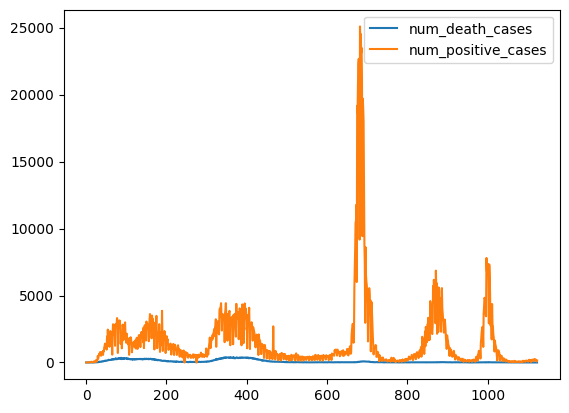

In [76]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DSA5900/LIMA_DEPARTMENT.csv')
df.info()

df.plot()

In [77]:
df['fecha_resultado'] = pd.to_datetime(df['fecha_resultado'], format='%Y/%m/%d')

In [78]:
df['Year'] = df['fecha_resultado'].dt.year
df['Month'] = df['fecha_resultado'].dt.month
df['Day'] = df['fecha_resultado'].dt.day
df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [79]:
df.drop(['fecha_resultado', 'departamento','num_death_cases', 'Year', 'Month', 'Day', ], axis=1, inplace= True)
df.columns = ['y', 'ds']

In [80]:
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

In [81]:
df['y'] = df['y'].cumsum()


<Axes: xlabel='ds'>

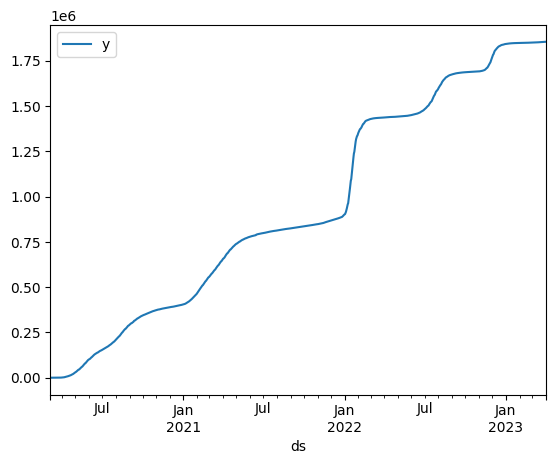

In [82]:
import numpy as np
#df = np.log(df['y']) # don't forget to transform the data back when making real predictions

df.plot()

In [83]:
df

,y
ds,
2020-03-06,1
2020-03-07,5
2020-03-08,7
2020-03-09,8
2020-03-10,9
...,...
2023-03-30,1854083
2023-03-31,1854267
2023-04-01,1854418


In [84]:
# msk = (df.index < len(df)-30)
# df_train = df[msk].copy()
# df_test = df[~msk].copy()

# Splitting the data into training and testing sets
train_size = int(len(df['y']) * 0.8)
df_train = df['y'][:train_size]
df_test = df['y'][train_size:]
len(df_test)

225

# Step 1: Check for stationarity of time series

## Method #1: time series plot

## Method #2: ACF plot and PACF plot

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


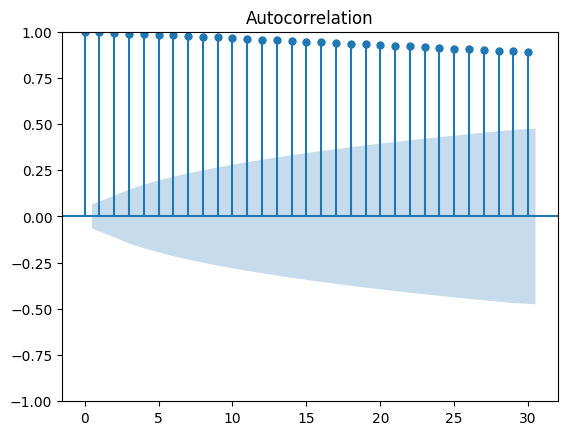

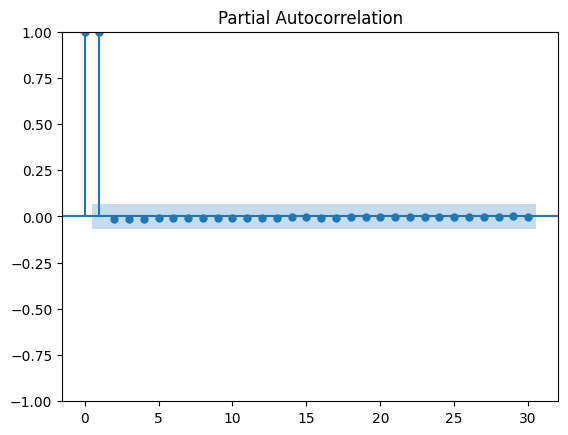

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test

In [87]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.943248095909215


## Transform to stationary: differencing

<Axes: xlabel='ds'>

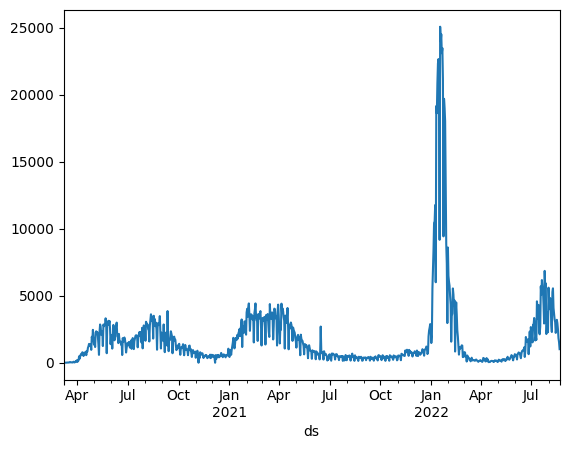

In [88]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


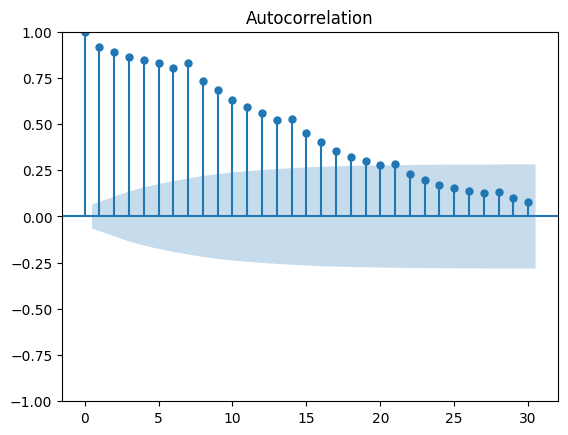

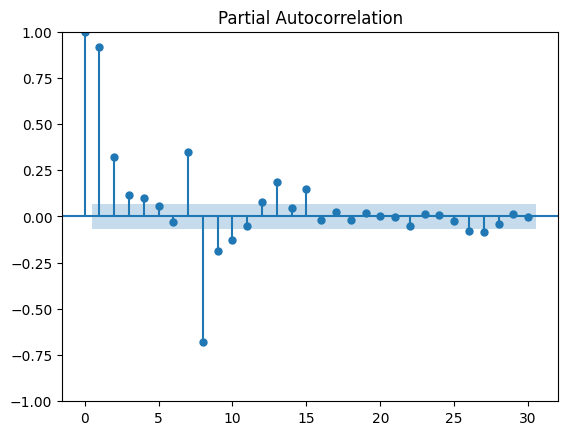

In [89]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [90]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0007544852004336105


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [91]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(7,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  899
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -7428.207
Date:                Thu, 27 Apr 2023   AIC                          14874.414
Time:                        10:30:22   BIC                          14917.615
Sample:                    03-06-2020   HQIC                         14890.919
                         - 08-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1594      0.014     11.061      0.000       0.131       0.188
ar.L2          0.5021      0.013     39.953      0.000       0.477       0.527
ar.L3          0.1107      0.014      8.069      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 4: Make time series predictions

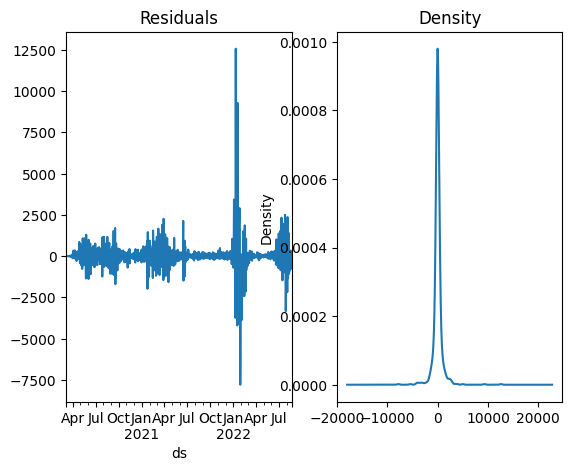

In [92]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


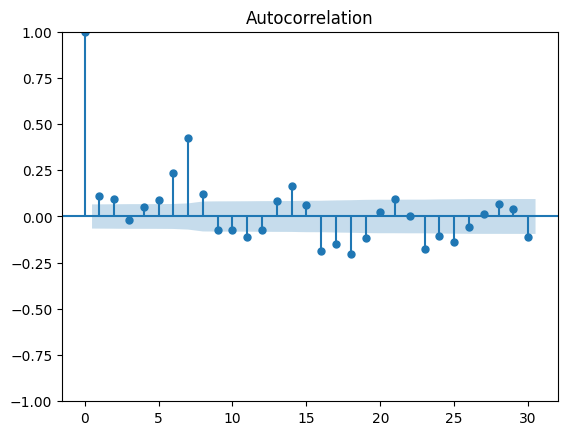

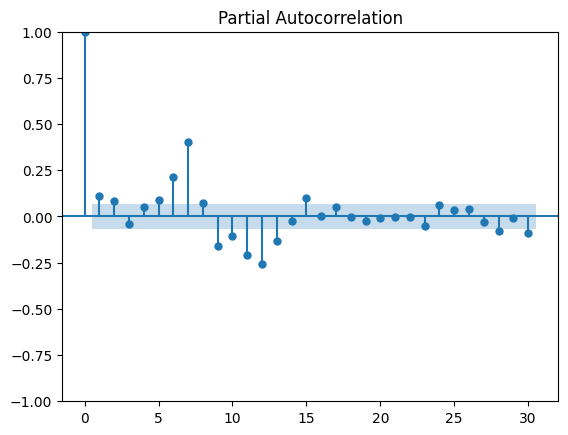

In [93]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: xlabel='ds'>

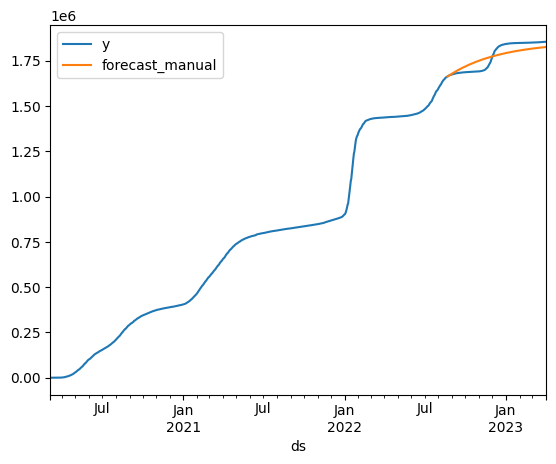

In [94]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# Optional: Auto-fit the ARIMA model

In [95]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True)

In [96]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  899
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -7494.771
Date:                Thu, 27 Apr 2023   AIC                          15003.542
Time:                        10:30:56   BIC                          15037.143
Sample:                    03-06-2020   HQIC                         15016.379
                         - 08-21-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.3608     46.529      1.878      0.060      -3.835     178.556
ar.L1          0.9640      0.004    224.161      0.000       0.956       0.972
ma.L1         -0.4423      0.013    -34.227      0.000      -0.468      -0.417
ma.L2         -0.1054      0.016     -6.503      0.000      -0.137      -0.074
ma.L3         -0.3792      0.014    -26.470      0.000      -0.407      -0.351
ma.L4          0.6793      0.010     71.233      0.000       0.661       0.698
sigma2      1.025e+06    1.4e+04     73.241      0.000    9.97e+05    1.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):             41076.88
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               9.66   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate model predictions

<Axes: xlabel='ds'>

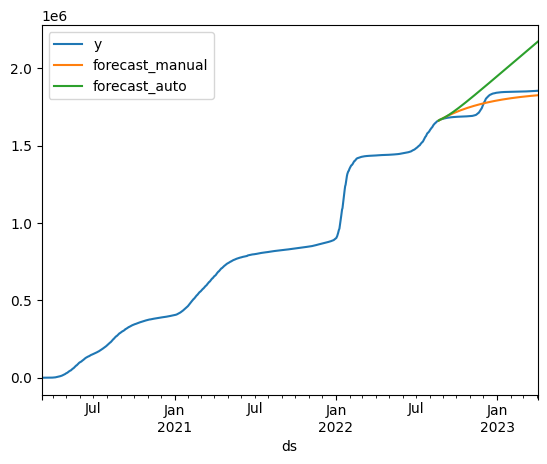

In [97]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

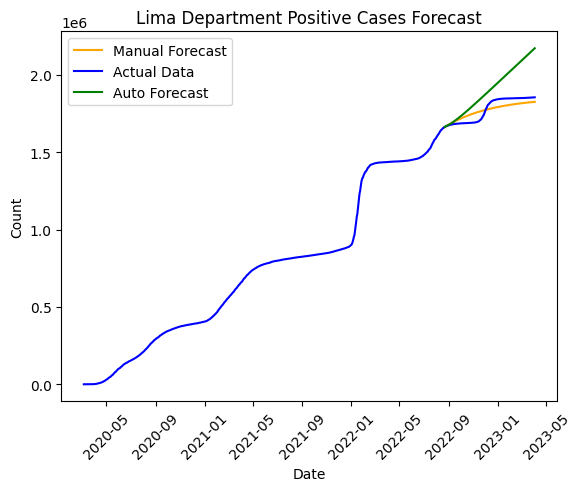

In [99]:
plt.figure()
plt.plot(df[['forecast_manual']], c='orange', label='Manual Forecast')
plt.plot(df[['y']], c='blue', label='Actual Data')
plt.plot(df[['forecast_auto']], c='green', label='Auto Forecast')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.title("Lima Department Positive Cases Forecast")
plt.legend()
plt.show()

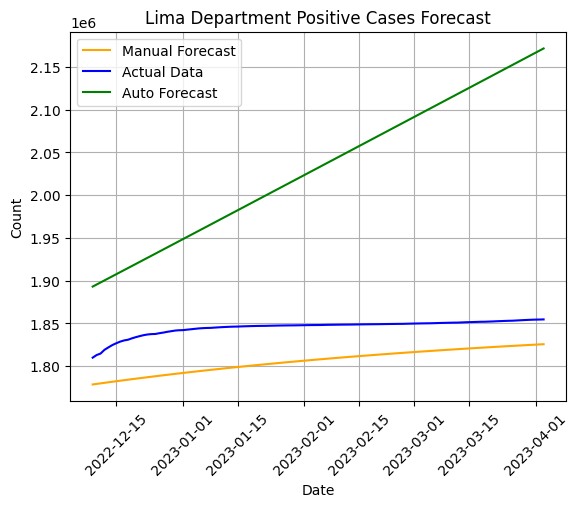

In [100]:
plt.figure()
plt.plot(df[['forecast_manual']][-116:], c='orange', label='Manual Forecast')
plt.plot(df[['y']][-116:], c='blue', label='Actual Data')
plt.plot(df[['forecast_auto']][-116:], c='green', label='Auto Forecast')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.title("Lima Department Positive Cases Forecast")
plt.legend()
plt.grid()
plt.show()

In [101]:
# Arima Department Positive Cases Error (Manual Forecast)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

#print(df_test.mean())
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

df_test_mean= df_test.mean()
print(f"Mean: {df_test_mean}")
print(f"RMSE percentage: {((rmse/df_test_mean)*100)}%")

mae - manual: 36364.16060479566
mape - manual: 0.020461354684171096
rmse - manual: 39604.43557570636
Mean: 1774071.0266666666
RMSE percentage: 2.2324041698668533%


In [102]:
# Arima Department Positive Cases Error (Automatic Forecast)
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

#print(df_test.mean())
print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

df_test_mean= df_test.mean()
print(f"Mean: {df_test_mean}")
print(f"RMSE percentage: {((rmse/df_test_mean)*100)}%")

mae - auto: 130116.39272629231
mape - auto: 0.07190706001558618
rmse - auto: 155734.39827297803
Mean: 1774071.0266666666
RMSE percentage: 8.778363207114099%


# Other suggestions